# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Project overview

In this project we will try to accommodate with the **unsupervised learning techniques**, using different algorithms such as K-Means, DBSCAN and Gaussian mixture models and others while tackling some common datasets. The scope is to use these algorithms for practicing different applications such as: **clustering**, **image segmentation**, **preprocessing**, **semi-supervised learning**, **anomaly detection** etc.

# Clustering for image segmentation

**Image segmentation** is the task of partitioning an image into multiple segments. In **semantic segmentation**, all pixels that are part of the same object type get assigned to the same segemnt. In **instance segmentation**, all pixels that are part of the same individual object are assigned to the same segment. Here, we are going to do something much simpler: **color segemtation**. We will simply assign pixels to the same segment if they have a similar color.

First, we will use Matplotlib's **imread()** functiomn to load the ladybug image:

In [2]:
import urllib.request
from sklearn.datasets import fetch_openml


images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x28fddefd5b0>)

In [3]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

The image is represented as a 3D array. The following code reshapes the array to get a long list of RGB colors, then it cluster these colors using K-Means:

In [4]:
from sklearn.cluster import KMeans


X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [5]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Let's plot the segmentated image using different numbers of colors:

Saving figure image_segmentation_diagram


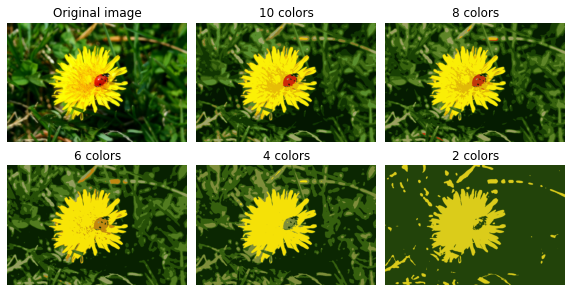

In [6]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

When we use fewer than 8 clusters, notice that the ladybug's flashy red color fails to get a cluster of its own: it gets merged with colors from the environment. This is because K-Means prefers clusters of similar sizes. The ladybug is small - much smaller than the rest of the image - so even though its color is flashy, K-Means fails to dedicate a cluster to it.

# Clustering for Preprocessing

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm. As an example of using clustering for dimensionality reduction, let's tackle the digits dataset, which is similar to the MNIST-like dataset containing 1797 grayscale 8x8 images representing the digits 0 to 9. 

First, let's load the dataset:

In [7]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

Now, let's split it into a training set and a test set:

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test, y_train, y_test = train_test_split(X_digits, y_digits)

Next, let's fit a Logistic Regression model on the raw dataset:

In [9]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

Let's evaluate its accuracy on the test set:

In [10]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline: 96.89% accuracy. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [11]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

Now let's evaluate the classification pipeline:

In [12]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

How much did the error rate drop?



In [13]:
1 - (1 - pipeline_score) / (1 - log_reg_score)


0.28571428571428414

How about that? We reduced the error rate by over 28%! But we chose the number of clusters k completely arbitrarily, we can surely do better. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for k is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of k is simply the one that results in the best classification performance.

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans_

[CV] END ..............................kmeans__n_clusters=35; total time=   5.9s
[CV] END ..............................kmeans__n_clusters=36; total time=   6.7s
[CV] END ..............................kmeans__n_clusters=36; total time=   6.2s
[CV] END ..............................kmeans__n_clusters=36; total time=   5.4s
[CV] END ..............................kmeans__n_clusters=37; total time=   6.4s
[CV] END ..............................kmeans__n_clusters=37; total time=   6.1s
[CV] END ..............................kmeans__n_clusters=37; total time=   4.9s
[CV] END ..............................kmeans__n_clusters=38; total time=   6.2s
[CV] END ..............................kmeans__n_clusters=38; total time=   6.0s
[CV] END ..............................kmeans__n_clusters=38; total time=   6.1s
[CV] END ..............................kmeans__n_clusters=39; total time=   6.0s
[CV] END ..............................kmeans__n_clusters=39; total time=   5.8s
[CV] END ...................

[CV] END ..............................kmeans__n_clusters=69; total time=   7.4s
[CV] END ..............................kmeans__n_clusters=70; total time=   7.5s
[CV] END ..............................kmeans__n_clusters=70; total time=   7.3s
[CV] END ..............................kmeans__n_clusters=70; total time=   7.3s
[CV] END ..............................kmeans__n_clusters=71; total time=   6.6s
[CV] END ..............................kmeans__n_clusters=71; total time=   6.9s
[CV] END ..............................kmeans__n_clusters=71; total time=   7.3s
[CV] END ..............................kmeans__n_clusters=72; total time=   6.5s
[CV] END ..............................kmeans__n_clusters=72; total time=   7.2s
[CV] END ..............................kmeans__n_clusters=72; total time=   6.3s
[CV] END ..............................kmeans__n_clusters=73; total time=   7.4s
[CV] END ..............................kmeans__n_clusters=73; total time=   7.1s
[CV] END ...................

C:\Users\mihae\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

let's look at the best value k and the performance of the resulting pipeline:

In [15]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [16]:
grid_clf.score(X_test, y_test)


0.9844444444444445

With k = 88 clusters, we get a significant accuracy boost, reaching 98.22% accuracy on the test set. Cool! 

# Clustering for Semi-Supervised Learning 

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [17]:
n_labeled = 50 
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

The accuracy is just 83.33%, It should come as no surprise that this is much lower than earlier, when we trained the model on the full tarining set. Let's see how we can do better. 

First, let's cluster the training set into 50 clusters. Then for each cluster, let's find the image closest to the centroid. We will call these images the **representative images**:

In [18]:
k =50 
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:



Saving figure representative_images_diagram


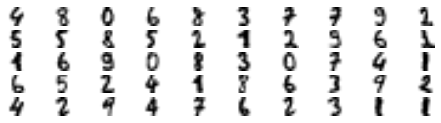

In [19]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [20]:
y_train[representative_digit_idx]


array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

Let's look at each image and manually label it:

In [21]:
y_representative_digits = np.array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [22]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [23]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

Now let's train a model again and look at its performance:

In [24]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.9333333333333333

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [25]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [26]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [27]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [28]:
log_reg.score(X_test, y_test)

0.94

With just 50 labeled instances (just 5 examples per class on average!), we got 94% performance, which is getting closer to the performance of logistic regression on the fully labeled digits dataset (which was 96.9%).


This is because the propagated labels are actually pretty good: their accuracy is close to 99%:

In [29]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])


0.9896907216494846

# DBSCAN

This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. Let;s test it on the moons dataset (which is a simple toy dataset to visualize clustering and classification algorithms):

In [30]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)


In [31]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [32]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

Some instances have a cluster index equal to -1, which means that they are considerated as anomalies by the aglorithm.

In [33]:
len(dbscan.core_sample_indices_)

808

In [34]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [35]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [36]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [37]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [38]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


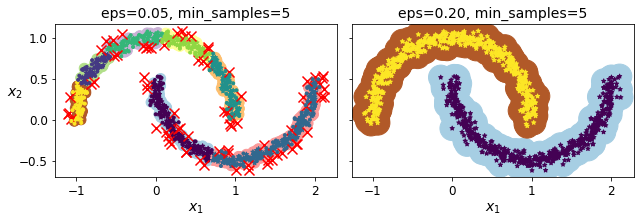

In [39]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()

As we can see, it identified quite a lot of anomalies, plus seven different clusters. Fortunaltely, if we widen each instance's neighboorhood by increasing **eps** to 0.20, we get the clusteing on the right, which looks perfect.

In [40]:
dbscan = dbscan2

Let's try to predict which cluster a new instance belongs to, using a KNeighborsClassifier algorithm:

In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instance, we can predict which cluster they must likely belong to and even estimate a probabily for each cluster:

In [42]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [43]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

In [44]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure cluster_classification_plot


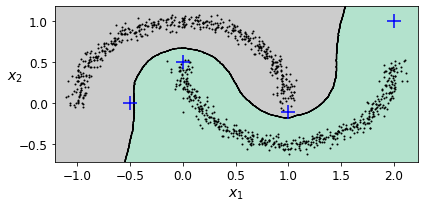

In [45]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [46]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

# Other Clustering Algorithms

## Agglomerative clustering

In [47]:
from sklearn.cluster import AgglomerativeClustering

In [48]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [49]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [50]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [51]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

## Spectral Clustering

In [52]:
from sklearn.cluster import SpectralClustering

In [53]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [54]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [55]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [56]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [57]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

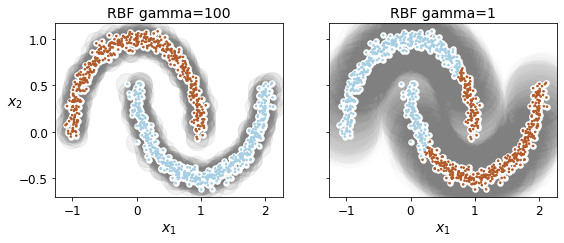

In [58]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

# Gaussian Mixtures

Now, let's dive into Gaussian Mixtures models, wich can be used for density estimation, clustering and anomaly detection.

In [60]:
from sklearn.datasets import make_blobs

In [61]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]


Let's train a Gaussian mixture model on the previous dataset:

In [62]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [63]:
gm.weights_

array([0.39025715, 0.40007391, 0.20966893])

In [68]:
gm.means_

array([[ 0.05131611,  0.07521837],
       [-1.40763156,  1.42708225],
       [ 3.39893794,  1.05928897]])

In [65]:
gm.covariances_

array([[[ 0.68799922,  0.79606357],
        [ 0.79606357,  1.21236106]],

       [[ 0.63479409,  0.72970799],
        [ 0.72970799,  1.1610351 ]],

       [[ 1.14833585, -0.03256179],
        [-0.03256179,  0.95490931]]])

In [66]:
gm.converged_

True

Let's see how many iterations it took:

In [67]:
gm.n_iter_

4

Let's predict which cluster each instaance belongs to and the probabilities that it came for each cluster:

In [69]:
gm.predict(X)

array([0, 0, 1, ..., 2, 2, 2], dtype=int64)

In [70]:
gm.predict_proba(X)

array([[9.76741808e-01, 6.78581203e-07, 2.32575136e-02],
       [9.82832955e-01, 6.76173663e-04, 1.64908714e-02],
       [7.46494398e-05, 9.99923327e-01, 2.02398402e-06],
       ...,
       [4.26050456e-07, 2.15512941e-26, 9.99999574e-01],
       [5.04987704e-16, 1.48083217e-41, 1.00000000e+00],
       [2.24602826e-15, 8.11457779e-41, 1.00000000e+00]])

This is a generative model, so let's sample new instances from it (and get their labels):

In [71]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.86944074, -0.32767626],
       [ 0.29836051,  0.28297011],
       [-2.8014927 , -0.09047309],
       [ 3.98203732,  1.49951491],
       [ 3.81677148,  0.53095244],
       [ 2.84104923, -0.73858639]])

In [72]:
y_new

array([0, 0, 1, 2, 2, 2])

Notice that they are sampled sequentially from each cluster.

We can also estimate the log of the probability density function (PDF) at any location using the score_samples() method:

In [73]:
gm.score_samples(X)

array([-2.60768954, -3.57110232, -3.32987086, ..., -3.51347241,
       -4.39798588, -3.80746532])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [74]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999215021

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [75]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)


Saving figure gaussian_mixtures_plot


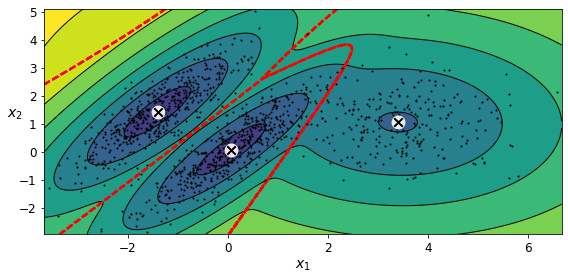

In [76]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

# Anomaly Detection using Gaussian Mixtures

**Anomaly detection** is useful in a wide variety of applications, such as fraud detection, detecting defective products in manufactoring or removing outliers from a dataset before training another model.

Gaussian Mixtures can be used for **anomaly detection**: instances located in low-density regions can be considered anomalies. We must define what density threshold we want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [77]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


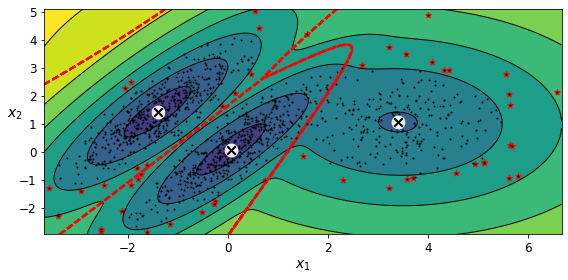

In [78]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()